## **Instructions**  

Run each cell in order. To see a different search trajectory, rerun the cell with "# search" at the top.

Make sure that the flowchart file is in the same directory as the notebook.

In [1]:
# Imports

from mpl_toolkits import mplot3d
from IPython.display import Image

import os, pylab 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import seaborn as sns

## **Background**  

A strategy in a motor task can be represented as a set of settings for relevant parameters. These parameters simplify the task into simpler components that the system attends to while executing the task. 

For example, in navigating a racecourse, it would be beneficial to attend to certain parameters: your speed along straight tracks as a function of the length of the track, your speed when approaching bends as a function of the curvature, your distance from either side of the track, the slope angle of the track you are on, and many others. 

In learning how to excel at a task, one could imagine making small adjustments to your current strategy to improve performance, while retaining the overall idea of the strategy (parametric shift). This would correspond to making small adjustments to parameter values to maximize performance. However, we sometimes realize that no amount of adjustment to our current strategy will further improve our performance and that the current performance is still short of some internal criterion (i.e. we think we can do better!). Hence, we would switch to a different strategy (categorical shift), beginning the adjustment process all over again. This would then correspond to a major shift in parameter values, to a combination of values that is drastically different from previously tested combinations.

## **Task**  

Instead of using an environment, the task will be an abstraction of the motor tasks alluded to; the agent's goal is to maximize its performance by finding good parameter values for a one-parameter function with local maxima and one global maximum.

Global maximum at (4.319319, 1229.335516)
Local maximum at (-4.579580, 353.363707)
Local maximum at (-0.035035, 300.461163)


Text(0.5,1,'Performance by parameter value')

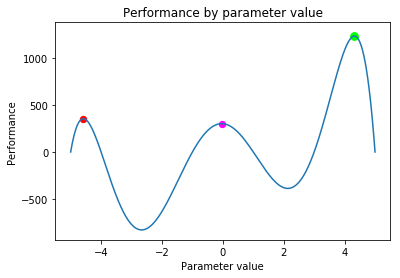

In [2]:
# Task function to convert parameters into performance

def taskFunc(params):
    x = params
    #y = -(x**4) + 5*(x**3) + 7*(x**2) - 29*x + 30
    y = -(x+5)*(x+4)*(x+1)*(x-1)*(x-3)*(x-5)
    return y 

fig1, ax1 = plt.subplots()
x = np.linspace(-5,5, num=1000)
y = taskFunc(x)
ax1.plot(x,y)

maxIndex = y.argmax()
print('Global maximum at (%f, %f)' %(x[maxIndex], y[maxIndex]))
ax1.scatter(x[maxIndex], y[maxIndex], s=60, color='#00ff00')

secondMaxIndex = y[0:300].argmax()
print('Local maximum at (%f, %f)' %(x[secondMaxIndex], y[secondMaxIndex]))
ax1.scatter(x[secondMaxIndex], y[secondMaxIndex], s=40, color='#ff0000')

thirdMaxIndex = y[400:500].argmax() + 400
print('Local maximum at (%f, %f)' %(x[thirdMaxIndex], y[thirdMaxIndex]))
ax1.scatter(x[thirdMaxIndex], y[thirdMaxIndex], s=40, color='#ff00ff')

ax1.set_ylabel('Performance')
ax1.set_xlabel('Parameter value')
ax1.set_title('Performance by parameter value')

## **Model**  

The model consists of three components:

**1.** A search agent that "learns" how to optimize its current strategy by making perturbations of decreasing step sizes to parameter values and then searching in the direction that improves its performance.

**2.** The search agent also possesses a working memory. The working memory stores the best performance and its associated parameter(s) for each recently explored strategy. If, by the end of a certain proportion of trials, the search agent is unable to find a strategy that satisfies its internal criterion, then it retrieves the best performing parameter values from memory and uses the remaining trials to optimize that strategy.

In [3]:
# Memory

class Memory:
    
    def __init__(self, size):
        self.size = size
        self.storage = [None]*size
    
    def updateMem(self, newItem):

        if (None not in self.storage):
            for i in range(0,self.size-1):
                self.storage[i] = self.storage[i+1]
            self.storage[self.size-1] = newItem
        else:
            self.storage[self.storage.index(None)] = newItem
            
    def retrieveBest(self):
        bestPerf = self.storage[0]
        for item in self.storage:
            if (item != None):
                if (item[0] > bestPerf[0]):
                    bestPerf = item
        return bestPerf
    
    def endExploreCheck(self, newItem):
        if (None in self.storage and self.storage.index(None) == 0):
            self.updateMem(newItem)

### Evidence accumulation

**$dEv$** : Change in evidence

**$dP$** : Change in performance

**$\alpha$** : Scaling factor for change in performance

**$c$** : Internal criterion

**$\tau$** : Timestep

**$\gamma$** : Timestep scaling factor


$$dEv = -\alpha \cdot d P + (cosh(\gamma \cdot \tau))\cdot (c-P)$$

**3.** The third component of the model is an accumulator that accumulates evidence for switching strategies. There are two sources of evidence. One is how much worse the current performance of the agent is compared to its internal criterion; one can think of this as how dissatisfied you are with your current performance given what you expect of your performance on a task. Another is how much your current performance has improved or deteriorated from your previous performance, and this source of evidence scales with time. Hence, early on in optimizing a strategy, evidence accumulation is primarily driven by changes in performance. When performance has stabilized (around a local maximum), the accumulation process becomes increasingly driven by the distance between the criterion and the current performance.

When the evidence accumulated crosses a threshold, the accumulator tells the search agent to look for a new strategy, ideally preventing it from spending too much time getting stuck in a local maximum or simply exploring highly sub-optimal parameter spaces.

In [4]:
# Accumulator

class Accumulator:

    def __init__(self, accumParams):
        self.currTrace = []
        self.currEv = accumParams['startEv']
        self.currCount = 0
        self.threshold = accumParams['threshold']
        self.alpha = accumParams['alpha']
        self.active = True
        
        # Time constant
        self.gamma = accumParams['gamma']
        
    def updateAccum(self, currPerf, deltaPerf, criterion):
        
        self.currCount += 1
        deltaEv = self.perfToEv(currPerf, deltaPerf, criterion, self.currCount)
        self.currEv += deltaEv

        # Non-negativity
        if (self.currEv < 0):
            self.currEv = 0
        
        # Trigger switch if accumulator reaches threshold
        if (self.currEv > self.threshold):
            self.switch = True
        
        self.currTrace.append(self.currEv)

        
    # How change in evidence is calculated
    def perfToEv(self, currPerf, deltaPerf, criterion, t):
        ev = -1*deltaPerf*self.alpha + (criterion-currPerf)*(np.cosh(self.gamma*t)-1)
        #print(-1*deltaPerf*self.alpha, (criterion-currPerf)*(np.cosh(self.gamma*t)-1))
        return ev

In [5]:
# Search Agent

class searchAgent:
    
    def __init__(self, agentParams):
        self.bounds = agentParams['bounds']
        self.searchStep = agentParams['searchStep']
        self.searchDelta = agentParams['searchDelta']
        self.searchDelta0 = agentParams['searchDelta']
        self.searchSign = agentParams['searchSign']
        self.mem = Memory(agentParams['memSize'])
        
        self.explored = []
        self.currMinGuess = 0
        self.currMaxGuess = 0
        
        self.currPerf = 0
        self.currBest = 0
        self.stratBest = [0,[]]
        
        self.criterion = agentParams['criterion']
        self.maxTrials = agentParams['maxTrials']
        self.exploreTrials = self.maxTrials*agentParams['proportion']
        
        self.switch = False
        
        
    def nextGuess(self, accum):
        if ((accum.active == False) or (self.switch == False)):
            guess = self.stratBest[1][0] + self.searchSign*self.searchStep*self.searchDelta
            if (guess < self.currMinGuess):
                self.currMinGuess = guess
            if (guess > self.currMaxGuess):
                self.currMaxGuess = guess
        
        
        else:
            # Ensures that the agent will switch to a new guess in an unexplored range of values
            self.explored
            guess = 0
            newGuess = False
            while (newGuess == False):
                newGuess = True
                guess = (np.random.rand(1)[0] - 0.5)*(self.bounds[1]-self.bounds[0])
                
                for ranges in self.explored:
                    if (ranges[0] <= guess <= ranges[1]):
                        newGuess = False
                        break
                
            self.currMinGuess = guess
            self.currMaxGuess = guess
        return guess
    
    def comparePerf(self, deltaPerf):
        
        # Check if new guess leads to better performance
        if (deltaPerf > 0):
                
            # New guess is better than the current best guess, so update best guess to reflect that
            self.stratBest = self.currPerf
            
        else:
            
            # New guess is worse than current best guess, so prepare to search in the opposite direction
            self.searchSign = -1*self.searchSign
            self.searchDelta = self.searchDelta*self.searchDelta0

In [6]:
# Search
np.random.seed(1)
agentParams = {'bounds': [-5, 5], 
               'searchStep': 0.2, 'searchDelta': 0.8, 'searchSign': 1, 
               'criterion': 700, 
               'maxTrials': 500, 'proportion': 0.9,
               'memSize': 3}

accumParams = {'threshold': 200, 'startEv': 0, 'alpha': 0.1, 'gamma': 0.001}

agent = searchAgent(agentParams)
accum = Accumulator(accumParams)

# Global Trace
globalTrace = pd.DataFrame(columns = ['Performance','Parameters', 'Best Performance', 'Best Parameters', 'Accumulated Evidence'])

for i in range(1, agent.maxTrials):

    if (i == 1):
        
        #guess = (np.random.rand(1)[0] - 0.5)*(agent.bounds[1]-agent.bounds[0])
        
        # Initialize first guess for demonstration purposes
        guess = -4
        agent.currMinGuess = guess
        agent.currMaxGuess = guess
        agent.stratBest = [float(taskFunc(guess)), [float(guess)]]

    else:
        
        guess = agent.nextGuess(accum)
        
    agent.currPerf = [float(taskFunc(guess)), [float(guess)]]
    
    if (accum.active == True):
        if (agent.switch == True):
            # Reset accumulator
            
            accum = Accumulator(accumParams)
            agent.switch = False
            
            agent.stratBest = agent.currPerf
            agent.searchDelta = agent.searchDelta0

        else:
            
            deltaPerf = agent.currPerf[0] - agent.stratBest[0]
            
            # Update accumulator
            accum.updateAccum(agent.currPerf[0], deltaPerf, agent.criterion)

            agent.comparePerf(deltaPerf)
                
        # Update traces of evidence for current strategy and overall
        if (accum.currEv >= accum.threshold):
            
            # When the accumulator accumulates enough evidence to switch, tell the accumulator to switch
            agent.switch = True
            agent.explored.append([agent.currMinGuess,agent.currMaxGuess])
            
            # Update memory with the best performance and corresponding parameter values from current strategy
            agent.mem.updateMem(agent.stratBest)
            
        if (i >= agent.exploreTrials):
            
            # When enough trials have been explored, turn off the accumulator
            accum.active = False
            
            # Check if anything has been stored in memory
            agent.mem.endExploreCheck(agent.stratBest)
            
            # Identify best remembered performance and the associated parameters
            agent.stratBest = agent.mem.retrieveBest()
            #print(stratBest)

        if (agent.currPerf[0] >= agent.criterion):
            
            # When current performance is greater than the criterion, turn off the accumulator          
            accum.active = False
            
    else:
        
        # Continue optimizing current strategy or strategy identified as best from memory
        deltaPerf = agent.currPerf[0] - agent.stratBest[0]
        agent.comparePerf(deltaPerf)

    tempItem = agent.currPerf.copy()
    tempItem.extend(agent.stratBest)
    tempItem.append(accum.currEv)
    globalTrace.loc[i] = tempItem

### **Sequence per timestep**  

![title](flowchart.png)

## **Results**  

After running the model above, we can look at how the agent searched the parameter space. Should it get stuck in a local maximum, the lower the maximum, the faster the agent should switch out of that strategy. It is possible for the agent to be stuck in a local maximum that is close to its internal criterion; this happens when the agent has finished its 'exploratory' trials but the accumulator has yet to gather enough evidence in favor of switching away from that sub-optimal strategy.

Furthermore, if the agent has not found a parameter value that satisfies its internal performance criterion by the end of its 'exploratory' trials, it should simply retrieve from its memory a recent best performing value and jump to that value, continuing to optimize that strategy in the remainder of the trials.

<IPython.core.display.Javascript object>


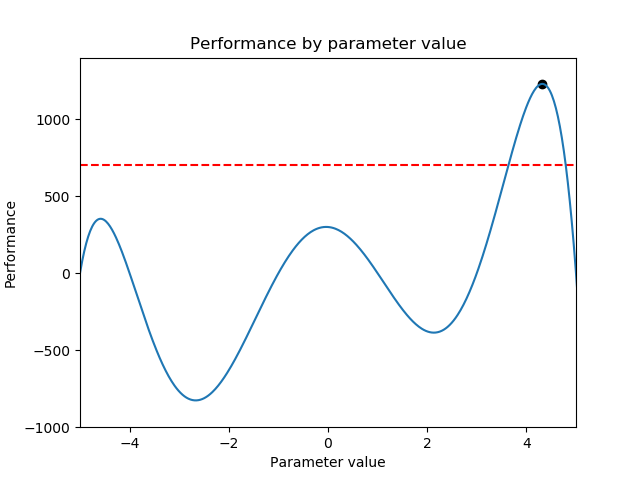

In [7]:
%matplotlib notebook

fig2, ax2 = plt.subplots()
ax2.set_xlabel('Parameter value')
ax2.set_ylabel('Performance')
plt.axhline(y=agent.criterion, color='red',linestyle='--')
x, y = [],[]
sc = ax2.scatter(x,y,color='#000000')
xLine = np.linspace(-10,10, num=1000)
yLine = taskFunc(xLine)
ax2.plot(xLine,yLine)
ax2.set_xlim(-5,5)
ax2.set_ylim(-1000,1400)
ax2.set_title('Performance by parameter value')
xcopy = globalTrace['Parameters'].values
ycopy = globalTrace['Performance'].values

def animate(i):
    x = xcopy[i][0]
    y = ycopy[i]
    #x.append(xcopy[i][0])
    #y.append(ycopy[i])
    sc.set_offsets(np.c_[x,y])

ani = animation.FuncAnimation(fig2, animate, 
                frames=agent.maxTrials, interval=100, repeat=False, blit=True) 
plt.show()

We can also trace how the accumulator gathers evidence over time. For each strategy switch, we would expect to see a curve that starts at baseline (0), and accelerates towards the threshold. During the initial stages of each strategy optimization, most of the evidence for switching comes from how much performance deteriorates when trying out a new parameter value. However, after having sufficiently explored the current strategy and arriving at what seems to be a local maximum, it becomes increasingly more important to gauge how much the agent is underperforming (compared to its internal criterion) and use that as another source of evidence to support the agent's switch to a new strategy.

<IPython.core.display.Javascript object>


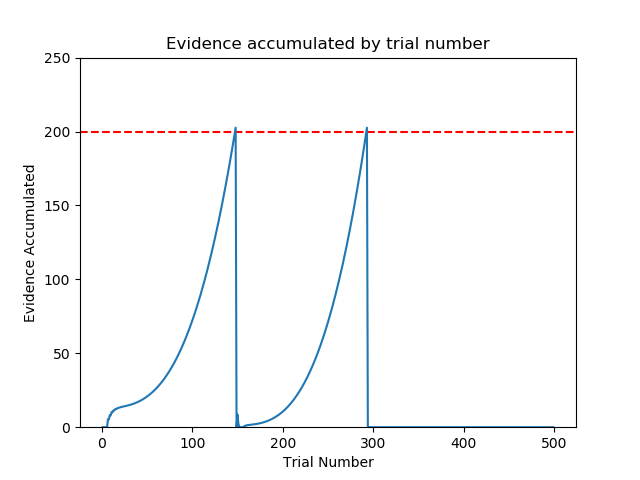

In [8]:
fig3, ax3 = plt.subplots()
ax3.set_xlabel('Trial Number')
ax3.set_ylabel('Evidence Accumulated')
ax3.set_title('Evidence accumulated by trial number')
plt.axhline(y=accum.threshold, color='red',linestyle='--')
ax3.set_ylim(0,250)
ax3.plot(globalTrace['Accumulated Evidence'])

## **Conclusions**

To recap, the model currently possesses the following features:
- A search agent that optimizes its current strategy by trying out new parameter values in the direction of improving performance
- An evidence accumulator to help the agent decide when / if to switch strategies
- A memory that stores the best performing parameter values of the n most recently explored strategies

Potential extensions:
- Searching over multiple parameters using similar principles
- Have the search agent recognize when it is on a trajectory it has explored before, and not just when it had already tested that exact parameter value
- Refine the accumulation process to be more reflective of the contributions of the two sources of evidence
- Add noise to performance estimation